<a href="https://colab.research.google.com/github/yundddd/graph_generator/blob/models/GNN_models_experiment%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
1. https://github.com/emalgorithm/directed-graph-neural-network/tree/main
2. https://emanuelerossi.co.uk/blog/2023/dirgnn/

# Import dependencies

In [1]:
pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 40.3 MB/s eta 0:00:00


In [2]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.3 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.nn import ModuleList, Linear, ReLU, GRU
from torch_geometric.nn import (
    SAGEConv,
    GCNConv,
    GATConv,
    global_mean_pool,
    global_max_pool,
    global_add_pool,
)
from torch_geometric.data import Data, DataLoader, Dataset

import networkx as nx
import numpy as np
import os
import os.path as osp
import pandas as pd

import matplotlib.pyplot as plt

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load PyG dataset

In [33]:
FEATURE_DIMENSION = 9
TIMESTAMP_FEATURE_INDEX = 3
HEALTHY_NODE_LABEL = 0
ROOT_CAUSE_NODE_LABEL = 1
NUM_CLASSES = 2
NUM_NODES = 29

In [34]:
class SimulatedDataset():
  def __init__(self, edge_idx_path, node_features_path, fault_label_path):
    self.edge_idx_path = edge_idx_path
    self.node_features_path = node_features_path
    self.fault_label_path = fault_label_path

    self.edge_index = self.get_edge_index(self.edge_idx_path)
    self.node_features, self.node_labels, self.time_stamps = self.get_node_features(self.node_features_path, self.fault_label_path)
    self.dataset_stats()


  def get_edge_index(self, path):
      edges = []
      with open(path, "r") as output:
        i = 0
        for line in output:
          edge = line.strip().split(',')
          edges.append([int(edge[0]), int(edge[1])])
      return torch.tensor(edges, dtype=torch.long).t().contiguous() # put edges into COO format

  def get_node_at_fault(self, path):
    node_at_fault, timestamp_of_fault = 0, 0
    with open(fault_label_path, "r") as output:
      ind = 0
      for line in output:
        node_at_fault, timestamp_of_fault = line.strip().split(',')
        ind += 1
      assert ind == 1 # there should only be one line in this file
    return int(node_at_fault), int(timestamp_of_fault)

  def get_node_features(self, node_features_path, fault_label_path):
    node_features, node_labels, time_stamps = [], [], []
    node_at_fault, timestamp_of_fault = self.get_node_at_fault(fault_label_path)
    with open(node_features_path, "r") as output:
      for line in output:
        items = line.strip().split(',')
        features = [list(map(int, items[i + 1 : i + FEATURE_DIMENSION + 1]))
                          for i in range(0, len(items), FEATURE_DIMENSION + 1)]
        time = max([node[TIMESTAMP_FEATURE_INDEX] for node in features]) # features[node_at_fault][TIMESTAMP_FEATURE_INDEX]
        features = torch.tensor(features)
        node_features.append(features)
        labels = [HEALTHY_NODE_LABEL] * features.shape[0]
        if time >= timestamp_of_fault:
          labels[node_at_fault] = ROOT_CAUSE_NODE_LABEL
        labels = torch.tensor(labels).reshape(features.shape[0])
        node_labels.append(labels)
        time_stamps.append(time)
    return node_features, node_labels, time_stamps

  def dataset_stats(self):
    self.feature_dimension = self.node_features[0].shape[1]
    self.num_nodes = self.node_features[0].shape[0]
    self.num_edges = self.edge_index.shape[1]
    self.num_graphs = len(self.node_features)
    self.num_classes = 2

  def report_dataset_stats(self):
    print(f'Number of nodes: {self.num_nodes}')
    print(f'Number of edges: {self.num_edges}')
    print(f'Number of graphs: {self.num_graphs}')
    print(f'Number of classes: {self.num_classes}')
    print(f'Feature dimension: {self.feature_dimension}')
    print(f'Node features: {self.node_features}')
    print(f'Node labels: {self.node_labels}')
    print(f'Edge index: {self.edge_index}')

## Helper functions

In [35]:
def get_injection_time(file_name):
  return file_name.split('_')[-1].split('.')[0]

In [36]:
def load_timestamp_instance(raw_data_path, subfolder, injection_time):
  instance = raw_data_path[subfolder][injection_time]
  pyg_dataset = SimulatedDataset(instance['edge_idx_path'], instance['node_features_path'], instance['fault_label_path'])

  data_list = []
  for i in range(pyg_dataset.num_graphs):
      x = pyg_dataset.node_features[i]
      y = pyg_dataset.node_labels[i]
      edge_index = pyg_dataset.edge_index
      timestamp = pyg_dataset.time_stamps[i]

      graph_data = Data(timestamp=timestamp, x=x, y=y, edge_index=edge_index)
      data_list.append(graph_data)

  return data_list

In [37]:
def randomly_sample_instances(num_samples, raw_data_path, subfolder):
  injection_times = [get_injection_time(file_name) for file_name in os.listdir(os.path.join(auto_vehicle_folder, subfolder))]
  sampled_injection_times = np.random.choice(injection_times, num_samples, replace=False)
  instance_data_list = [load_timestamp_instance(raw_data_path, subfolder, injection_time) for injection_time in sampled_injection_times]
  return instance_data_list

In [38]:
def compute_class_weights(instance, num_classes):
  class_0, class_1, total = 0, 0, 0
  for data in instance:
    total += 1
    has1, has0 = 0, 0
    for y in data.y:
      if y == 0:
        has0 += 1
      else:
        has1 += 1
    if has0 > 0:
      class_0 += 1
    if has1 > 0:
      class_1 += 1

  print(f'Total number of graphs: {total}, Presence of class 0: {class_0}, Presence of class 1: {class_1}')
  r = class_0/class_1
  class_0 = float(total/class_0)
  class_1 = float(total/class_1*r)
  class_weights = torch.tensor([class_0, class_1])

  return class_weights

```
# Compute class weights example:
Total number of graphs: 9367, Presence of class 0: 9367, Presence of class 1: 2368
tensor([ 1.0000, 15.6472])
```



## Load simulated autonomous vehicle data

In the `auto_vehicle_folder`, each `subfolder` specifies a type of fault and contains `instances` of simulating this fault at different `injection times`.

Load each instance to `raw_data_path[subfolder][injection_time]`.

In [39]:
auto_vehicle_folder = '/content/drive/MyDrive/CS224 Project/autonomous_vehicle'

In [40]:
subfolders = list(os.listdir(auto_vehicle_folder))
subfolders.remove('.DS_Store')
subfolders

['crash_camera_driver1',
 'crash_tracker',
 'drop_raw_camera1_publish',
 'drop_raw_camera1_receive',
 'mutate_raw_camera1_publish']

In [41]:
raw_data_path = {}
for subfolder in subfolders:
  subfolder_path = os.path.join(auto_vehicle_folder, subfolder)
  raw_data_path[subfolder] = {}

  for file_name in os.listdir(subfolder_path):
    if 'inject' in file_name:
      injection_time = get_injection_time(file_name)
      node_features_path = os.path.join(subfolder_path, f'node_feature_inject_at_{injection_time}.csv')
      fault_label_path = os.path.join(subfolder_path, f'fault_label_inject_at_{injection_time}.csv')
      edge_idx_path = os.path.join(subfolder_path, 'edge_index.csv')
      raw_data_path[subfolder][injection_time] = {}
      raw_data_path[subfolder][injection_time]['node_features_path'] = node_features_path
      raw_data_path[subfolder][injection_time]['fault_label_path'] = fault_label_path
      raw_data_path[subfolder][injection_time]['edge_idx_path'] = edge_idx_path

In [42]:
instance = raw_data_path[subfolders[0]]['1100']
instance

{'node_features_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/node_feature_inject_at_1100.csv',
 'fault_label_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/fault_label_inject_at_1100.csv',
 'edge_idx_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/edge_index.csv'}

In [43]:
sum([len(raw_data_path[subfolders[i]]) for i in range(len(subfolders))])

200

# Models

In [4]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.nn import ModuleList, Linear
from torch_geometric.nn import (
    SAGEConv,
    GCNConv,
    GATConv,
)
from torch_geometric.nn.conv.gcn_conv import gcn_norm

In [5]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

## Directed graph conv layers

In [6]:
class DirectedGCNConv(nn.ModuleList):
    def __init__(self, in_channels, out_channels):
      super(DirectedGCNConv, self).__init__()
      self.src_to_dst_conv = GCNConv(in_channels, out_channels, aggr='mean', improved=True)
      self.dst_to_src_conv = GCNConv(in_channels, out_channels, aggr='mean', improved=True)

    def forward(self, x, edge_index):
      edge_index_out = edge_index
      edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)
      return self.src_to_dst_conv(x, edge_index_out) + self.dst_to_src_conv(x, edge_index_in)

In [7]:
class DirectedSAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DirectedSAGEConv, self).__init__()
        self.src_to_dst_conv = SAGEConv(in_channels, out_channels, aggr='mean')
        self.dst_to_src_conv = SAGEConv(in_channels, out_channels, aggr='mean')
        self.lin_self = Linear(in_channels, out_channels)
        #self.alpha = alpha

    def forward(self, x, edge_index):
        edge_index_out = edge_index
        edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)

        return self.lin_self(x) + self.src_to_dst_conv(x, edge_index_out) + self.dst_to_src_conv(x, edge_index_in)

        return (
            self.lin_self(x)
            + self.src_to_dst_conv(x, edge_index)
            + self.dst_to_src_conv(x, edge_index)
        )

In [8]:
class DirectedGATConv(torch.nn.Module):
  def __init__(self, in_channels, out_channels, heads):
        super(DirectedGATConv, self).__init__()

        self.input_dim = in_channels
        self.output_dim = out_channels
        self.heads = heads

        self.src_to_dst_conv = GATConv(in_channels, out_channels, aggr='mean', heads=heads)
        self.dst_to_src_conv = GATConv(in_channels, out_channels, aggr='mean', heads=heads)

  def forward(self, x, edge_index):
      edge_index_out = edge_index
      edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)

      return self.src_to_dst_conv(x, edge_index_out) + self.dst_to_src_conv(x, edge_index_in)

In [11]:
DirectedGCNConv(9, 18), DirectedSAGEConv(9, 18), DirectedGATConv(9, 18, 18)

(DirectedGCNConv(
   (0-1): 2 x GCNConv(9, 18)
 ),
 DirectedSAGEConv(
   (src_to_dst_conv): SAGEConv(9, 18, aggr=mean)
   (dst_to_src_conv): SAGEConv(9, 18, aggr=mean)
   (lin_self): Linear(in_features=9, out_features=18, bias=True)
 ),
 DirectedGATConv(
   (src_to_dst_conv): GATConv(9, 18, heads=18)
   (dst_to_src_conv): GATConv(9, 18, heads=18)
 ))

#Build models

## Spatial models

In [49]:
class spatialGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGCN, self).__init__()
        if not directed:
          self.conv1 = GCNConv(input_features, hidden_dim)
          self.conv2 = GCNConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedGCNConv(input_features, hidden_dim)
          self.conv2 = DirectedGCNConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        #x = self.dropout(x)


        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out

In [50]:
class spatialGraphSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGraphSAGE, self).__init__()
        if not directed:
          self.conv1 = SAGEConv(input_features, hidden_dim)
          self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedSAGEConv(input_features, hidden_dim)
          self.conv2 = DirectedSAGEConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        #x = self.dropout(x)


        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out

In [51]:
class spatialGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGAT, self).__init__()
        if not directed:
          heads = input_features * 2
          self.conv1 = GATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads = 1)
        if directed:
          heads = input_features * 2
          self.conv1 = DirectedGATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = DirectedGATConv(hidden_dim*heads, hidden_dim, heads = 1)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        #x = self.dropout(x)


        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out


## Spatiotemporal models

To learn temporal information from the simulated dataset, we combined RNN models with GNN by implementing LSTM and GRU for each node.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, GRU
from torch_geometric.nn import global_mean_pool

### Discrete timestamps

In [52]:
class GRUGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUGCN, self).__init__()
        if not directed:
          self.conv1 = GCNConv(input_features, hidden_dim)
          self.conv2 = GCNConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedGCNConv(input_features, hidden_dim)
          self.conv2 = DirectedGCNConv(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply GCN layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        #x = self.dropout(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        #x = x.reshape(29, 9)
        x = x.view(1, 29, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
            #h = torch.zeros(1, x.size(1), self.gru.hidden_size, device=x.device)
        else:
            out, h = self.gru(x, h)


        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

In [53]:
class GRUSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUSAGE, self).__init__()
        if not directed:
          self.conv1 = SAGEConv(input_features, hidden_dim)
          self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedSAGEConv(input_features, hidden_dim)
          self.conv2 = DirectedSAGEConv(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply SAGConv layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        x = x.view(1, 29, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)


        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

In [54]:
class GRUGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUGAT, self).__init__()
        if not directed:
          heads = input_features * 2
          self.conv1 = GATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads = 1)
        if directed:
          heads = input_features * 2
          self.conv1 = DirectedGATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = DirectedGATConv(hidden_dim*heads, hidden_dim, heads = 1)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply SAGConv layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        x = x.view(1, 29, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)


        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

#Train and evaluate models

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import copy

In [56]:
def spatial_train(model, loader, class_weights, num_epoch, verbose, lr=0.001, weight_decay=5e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Define optimizer once

  model.train()
  rec_improve = None
  best_rec = None
  best_model = None

  for epoch in range(num_epoch):
      preds = []
      targets = []
      bp_counts = 0

      if class_weights is True:
          loss_function = torch.nn.CrossEntropyLoss(weight=compute_class_weights(loader, output_classes))
      else:
          loss_function = torch.nn.CrossEntropyLoss()

      for data in loader:  # Assuming data_loader provides data for each time step
        i = 0
        num_graphs = len(instance)
        optimizer.zero_grad()
        i += 1

        out = model(data)

        # Calculate accuracy
        _, pred = torch.max(out, 1)

        preds.append(out)
        targets.append(data.y.view(-1))

        if (pred == data.y.view(-1)).sum().item()/data.y.size(0) < 1:
          loss = loss_function(out, data.y.view(-1))
          loss.backward()
          optimizer.step()
          bp_counts += 1

      t_l = loss_function(torch.cat(preds), torch.cat(targets))
      acc = accuracy_score(torch.cat(targets), torch.cat(preds).argmax(dim=1))
      f1 = f1_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro')
      rec = recall_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro', zero_division=np.nan)

      if verbose:
        print(f'Epoch {epoch+1}, Total weighted loss: {t_l:.5f}, Macro recall: {rec:.5f}, Total accuracy: {acc:.5f}, Macro F1-score: {f1:.5f}. Loss backpropagated {bp_counts} times.')

      if best_rec == None:
        best_rec = rec
        best_model = copy.deepcopy(model)
      rec_improve = float(rec/best_rec)
      best_rec = max(rec, best_rec)
      if rec_improve > 1.0:
        best_model = copy.deepcopy(model)
      if rec_improve < (0.95+0.01*(epoch-1)):
          print('Recall score not improving. Early stopping triggered.')
          model = best_model
          return best_model
  model = best_model
  return best_model

In [57]:
def spatial_evaluate(model, model_name, loader, plt_confusion_matrix = True):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():  # Disable gradient tracking
      for data in loader:
          data.x = data.x.float()  # Ensure features are in float format
          out = model(data)  # Forward pass
          pred = out.argmax(dim=1)  # Get predictions
          preds.append(pred.cpu())  # Store predictions on CPU
          targets.append(data.y.cpu())  # Store true labels on CPU

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    report = classification_report(targets, preds, digits=4, zero_division=0)
    print(f'Model: {model_name}')
    print('====================')
    print(report)

    if plt_confusion_matrix:
      generate_cm(targets, preds, model_name)

In [58]:
def spatiotemporal_train(model, loader, class_weights, num_epoch, verbose, lr=0.001, weight_decay=5e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Define optimizer once

  model.train()
  rec_improve = None
  best_rec = None
  best_model = None

  for epoch in range(num_epoch):
      preds = []
      targets = []
      bp_counts = 0
      for instance in loader:
        h = None
        i = 0
        if class_weights is True:
          loss_function = torch.nn.CrossEntropyLoss(weight=compute_class_weights(instance, output_classes))
        else:
          loss_function = torch.nn.CrossEntropyLoss()

        for data in instance:  # Assuming data_loader provides data for each time step
          optimizer.zero_grad()
          i += 1

          if h is None:
            h = torch.zeros(1, data.x.size(0), model.gru.hidden_size, device=data.x.device)
            out, h = model(data.x.float(), data.edge_index, h)  # Detach h to prevent backprop through the entire history
          else:
            out, h = model(data.x.float(), data.edge_index, h.detach())   # Detach h to prevent backprop through the entire history

          # Calculate accuracy
          _, pred = torch.max(out, 1)

          preds.append(out)
          targets.append(data.y.view(-1))

          if (pred == data.y.view(-1)).sum().item()/data.y.size(0) < 1:
            loss = loss_function(out, data.y.view(-1))
            loss.backward()
            optimizer.step()
            bp_counts += 1 #counts how many times the model backpropagates

      t_l = loss_function(torch.cat(preds), torch.cat(targets))
      acc = accuracy_score(torch.cat(targets), torch.cat(preds).argmax(dim=1))
      f1 = f1_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro')
      rec = recall_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro', zero_division=np.nan)

      if verbose:
        print(f'Epoch {epoch+1}, Total weighted loss: {t_l:.5f}, Macro recall: {rec:.5f}, Total accuracy: {acc:.5f}, Macro F1-score: {f1:.5f}. Loss backpropagated {bp_counts} times.')

      if best_rec == None:
        best_rec = rec
        best_model = copy.deepcopy(model)
      rec_improve = float(rec/best_rec)
      best_rec = max(rec, best_rec)
      if rec_improve > 1.0:
        best_model = copy.deepcopy(model)
      if rec_improve < (0.95+0.01*(epoch-1)):
          print('Recall score not improving. Early stopping triggered.')
          model = best_model
          return best_model
  model = best_model
  return best_model

In [59]:
def spatiotemporal_evaluate(model, model_name, loader, plt_confusion_matrix = True):
    model.eval()
    preds = []
    targets = []
    total = 0
    correct = 0
    with torch.no_grad():
        h = None
        for instance in loader:
            for data in instance:
                  data.x = data.x.float()
                  out, h = model(data.x, data.edge_index, h)
                  _, pred = torch.max(out, 1)
                  preds.append(pred.cpu())
                  targets.append(data.y.cpu())
                  total += data.y.size(0)
                  correct += (pred == data.y.view(-1)).sum().item()

    accuracy = 100 * correct / total
    preds = torch.cat(preds)
    targets = torch.cat(targets)

    report = classification_report(targets, preds, digits=4, zero_division=0)
    print(f'Model: {model_name}')
    print('====================')
    print(report)

    if plt_confusion_matrix:
      generate_cm(targets, preds, model_name)

In [60]:
def apply_model(setting, model_name, input_features, hidden_dim, output_classes):
    model = MODELS[setting][model_name](input_features, hidden_dim, output_classes)
    return model

In [61]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import Colormap

colors = {
    'Undirected_GCN': 'Reds',
    'Undirected_GraphSAGE':'Wistia',
    'Undirected_GAT': 'Blues',
    'Directed_GCN': 'Purples',
    'Directed_GraphSAGE':'Oranges',
    'Directed_GAT': 'Greens',
    'Undirected_GRUGCN': 'PuRd',
    'Undirected_GRUSAGE': 'OrRd',
    'Undirected_GRUGAT': 'GnBu',
    'Directed_GRUGCN': 'RdPu',
    'Directed_GRUSAGE': 'YlOrRd',
    'Directed_GRUGAT': 'BuGn',
}

In [62]:
def generate_cm(y_true, y_pred, model_name = None, colors = colors):
  cm = confusion_matrix(y_true, y_pred)

  sns.heatmap(cm, annot=True, fmt = 'd', cmap=colors[model_name])
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  if model_name != None:
    plt.title(f'{model_name} Confusion Matrix')
  plt.show()

In [63]:
def spatial_data_loader(instance_data_list, batch_size=1, shuffle=True):
  instance_data_list_flattened = [item for sublist in instance_data_list for item in sublist]
  return DataLoader(instance_data_list_flattened, batch_size=batch_size, shuffle=shuffle)

In [64]:
def spatiotemporal_data_loader(instance_data_list, batch_size=1, shuffle=True):
  return DataLoader(instance_data_list, batch_size=batch_size, shuffle=shuffle)

# Compare models

**Precision**: Measures the accuracy of positive predictions.

**Recall**: Measures the model’s ability to find all relevant instances of each class.

**F1-Score**: The harmonic mean of precision and recall, which balances the two metrics.

**Support**: The number of true instances for each class.

**Macro Average**: Takes the average of each metric without considering the class support, providing an unweighted view.

**Weighted Average**: Takes the average of each metric, weighted by the number of instances in each class.

In [65]:
input_dim = FEATURE_DIMENSION
hidden_dim = input_dim * 2
output_classes = NUM_CLASSES
settings = ['spatial', 'spatiotemporal']
model_names = ['DirectedGCN', 'DirectedGraphSAGE', 'DirectedGAT', 'GRUGCN', 'GRUSAGE']

In [66]:
MODELS = {}
MODELS['spatial'] = {
    'Undirected_GCN': spatialGCN(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GraphSAGE':spatialGraphSAGE(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GAT': spatialGAT(input_dim, hidden_dim, output_classes, directed=False),
    'Directed_GCN': spatialGCN(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GraphSAGE':spatialGraphSAGE(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GAT': spatialGAT(input_dim, hidden_dim, output_classes, directed=True),
    'load': spatial_data_loader,
    'train': spatial_train,
    'evaluate': spatial_evaluate,
    }
MODELS['spatiotemporal'] = {
    'Undirected_GRUGCN': GRUGCN(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GRUSAGE': GRUSAGE(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GRUGAT': GRUGAT(input_dim, hidden_dim, output_classes, directed=False),
    'Directed_GRUGCN': GRUGCN(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GRUSAGE': GRUSAGE(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GRUGAT': GRUGAT(input_dim, hidden_dim, output_classes, directed=True),
    'load': spatiotemporal_data_loader,
    'train': spatiotemporal_train,
    'evaluate': spatiotemporal_evaluate,
    }

In [68]:
for setting in settings:
  for model_name in MODELS[setting].keys():
    print(model_name)
    print(MODELS[setting][model_name])

Undirected_GCN
spatialGCN(
  (conv1): GCNConv(9, 18)
  (conv2): GCNConv(18, 18)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)
Undirected_GraphSAGE
spatialGraphSAGE(
  (conv1): SAGEConv(9, 18, aggr=mean)
  (conv2): SAGEConv(18, 18, aggr=mean)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)
Undirected_GAT
spatialGAT(
  (conv1): GATConv(9, 18, heads=18)
  (conv2): GATConv(324, 18, heads=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)
Directed_GCN
spatialGCN(
  (conv1): DirectedGCNConv(
    (0-1): 2 x GCNConv(9, 18)
  )
  (conv2): DirectedGCNConv(
    (0-1): 2 x GCNConv(18, 18)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)
Directed_GraphSAGE
spatialGraphSAGE(
  (conv1): DirectedSAGEConv(
    (src_to_dst_conv): SAGEConv(9, 18, aggr=

## Helper functions

In [ ]:
def generate_comparative_cases(num_samples, instance_types, raw_data_path):
  compare_cases_list = []
  for i in range(len(instance_types)):
    compare_cases = {}
    training_instance = instance_types[i]
    training_instance_data_list = randomly_sample_instances(num_samples*2, raw_data_path, training_instance)
    train_instance_data_list, test_data_list1 = training_instance_data_list[:num_samples], training_instance_data_list[num_samples:]
    compare_cases[f'Training data list on a single error type: {training_instance}, {num_samples} samples'] = train_instance_data_list
    compare_cases[f'How does the model perform on unseen data, of the same error type?: {training_instance}, {num_samples} samples'] = test_data_list1
    for j in range(len(instance_types)):
      if j != i:
        test_data_list = randomly_sample_instances(num_samples, raw_data_path, instance_types[j])
        compare_cases[f'How does the model perform on unseen data, of a different error type?: {instance_types[j]}, {num_samples} samples'] = test_data_list
    compare_cases_list.append(compare_cases)
  return compare_cases_list

In [ ]:
def save_model(model, path, file_name, optimizer = None):
  torch.save(model.state_dict(), os.path.join(path, f'{file_name}_weights.pt'))
  if optimizer is not None:
    torch.save(optimizer.state_dict(), os.path.join(path, f'{file_name}_optimizer.pt'))
  torch.save(model, os.path.join(path, f'{file_name}_full.pt'))

In [ ]:
experiment_datalists = generate_comparative_cases(1, subfolders[:2], raw_data_path)

In [ ]:
import pickle
with open('experiment_datalists.pkl', 'wb') as file:
    pickle.dump(experiment_datalists, file)

In [ ]:
for experiment in experiment_datalists:
  print(experiment.keys())

dict_keys(['Training data list on a single error type: crash_camera_driver1, 1 samples', 'How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples', 'How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples'])
dict_keys(['Training data list on a single error type: crash_tracker, 1 samples', 'How does the model perform on unseen data, of the same error type?: crash_tracker, 1 samples', 'How does the model perform on unseen data, of a different error type?: crash_camera_driver1, 1 samples'])


In [ ]:
settings = ['Undirected', 'Directed']

### Spatial model experiments: Undirected vs. Directed

In [ ]:
train_case = 'Training data list on a single error type: crash_camera_driver1, 1 samples'
train_loader = spatial_data_loader(experiment_datalists[0]['Training data list on a single error type: crash_camera_driver1, 1 samples'])

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
test1 = 'How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples'
test2 = 'How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples'

test_loader1 = spatial_data_loader(experiment_datalists[0][test1])
test_loader2 = spatial_data_loader(experiment_datalists[0][test2])



Begin training Undirected_GCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.47635, Macro recall: 0.54170, Total accuracy: 0.98252, Macro F1-score: 0.53490. Loss backpropagated 3291 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.45984, Macro recall: 0.53634, Total accuracy: 0.98342, Macro F1-score: 0.53232. Loss backpropagated 3358 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.48073, Macro recall: 0.50058, Total accuracy: 0.98983, Macro F1-score: 0.50011. Loss backpropagated 2476 times.
Recall score not improving. Early stopping triggered.


Test 1: Evaluate Undirected_GCN on the training dataset.
Model: Undirected_GCN
              precision    recall  f1-score   support

           0     0.9

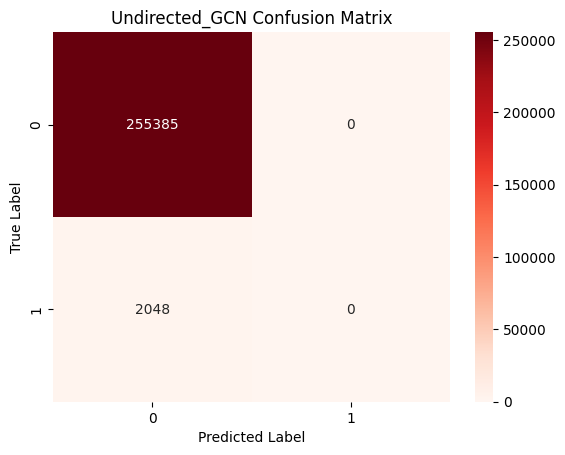



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GCN
              precision    recall  f1-score   support

           0     0.9920    1.0000    0.9960    254399
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9920    256447
   macro avg     0.4960    0.5000    0.4980    256447
weighted avg     0.9841    0.9920    0.9880    256447



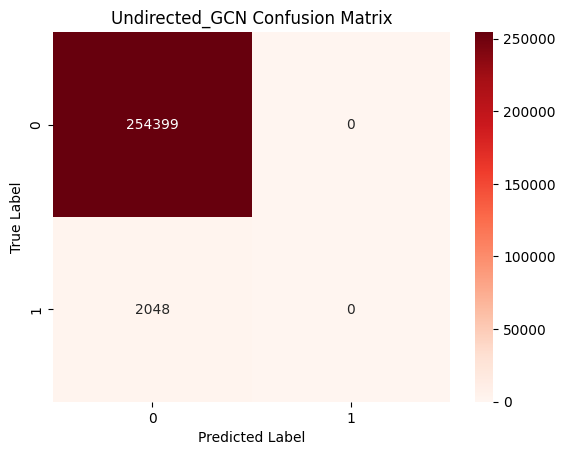



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GCN
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



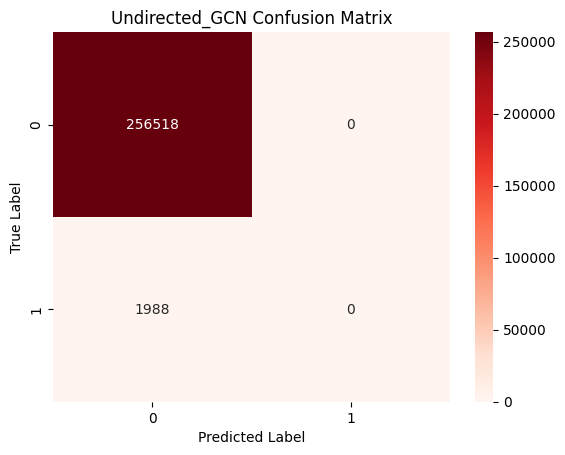



Begin training Directed_GCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.42983, Macro recall: 0.73764, Total accuracy: 0.98351, Macro F1-score: 0.65587. Loss backpropagated 3146 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.38561, Macro recall: 0.78232, Total accuracy: 0.97894, Macro F1-score: 0.64747. Loss backpropagated 3885 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.37810, Macro recall: 0.82061, Total accuracy: 0.98140, Macro F1-score: 0.67520. Loss backpropagated 3590 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.37036, Macro recall: 0.85019, Total accuracy: 0.98289, Macro F1-score: 0.69542. Loss backpropagat

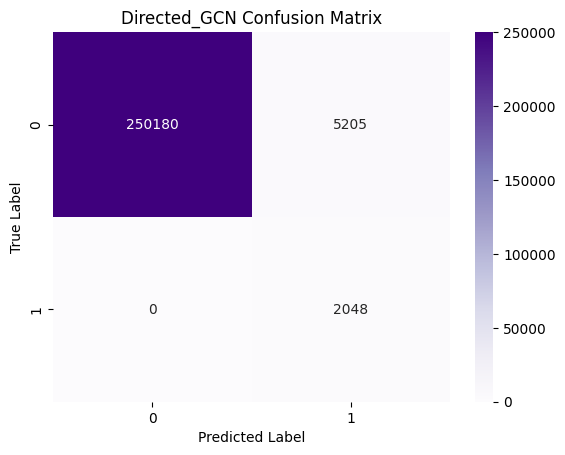



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GCN
              precision    recall  f1-score   support

           0     1.0000    0.9792    0.9895    254399
           1     0.2790    1.0000    0.4363      2048

    accuracy                         0.9794    256447
   macro avg     0.6395    0.9896    0.7129    256447
weighted avg     0.9942    0.9794    0.9851    256447



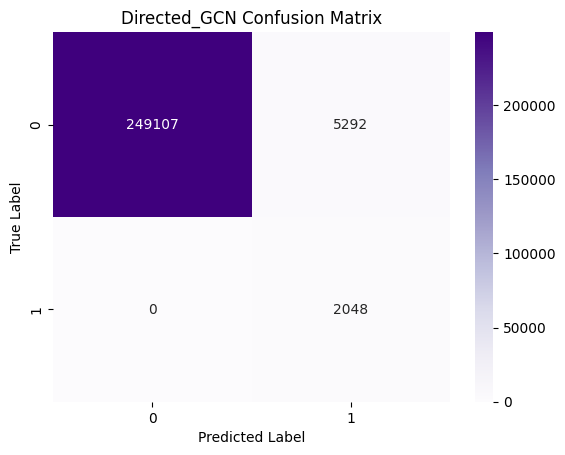



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GCN
              precision    recall  f1-score   support

           0     0.9951    0.9819    0.9884    256518
           1     0.1386    0.3768    0.2027      1988

    accuracy                         0.9772    258506
   macro avg     0.5669    0.6793    0.5955    258506
weighted avg     0.9885    0.9772    0.9824    258506



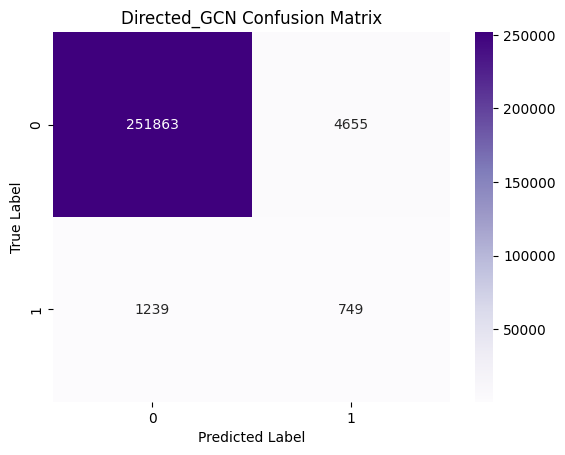

In [ ]:
#GCN

for setting in settings:
  model_name = f'{setting}_GCN'
  model = MODELS['spatial'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatial']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatial']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)




Begin training Undirected_GraphSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.46259, Macro recall: 0.56996, Total accuracy: 0.97900, Macro F1-score: 0.54703. Loss backpropagated 3724 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.45800, Macro recall: 0.54034, Total accuracy: 0.98223, Macro F1-score: 0.53330. Loss backpropagated 3502 times.
Recall score not improving. Early stopping triggered.


Test 1: Evaluate Undirected_GraphSAGE on the training dataset.
Model: Undirected_GraphSAGE
              precision    recall  f1-score   support

           0     0.9920    1.0000    0.9960    255385
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9920    257433
   macro avg     0.4960    0.5000    0.4980    257433
weighted avg

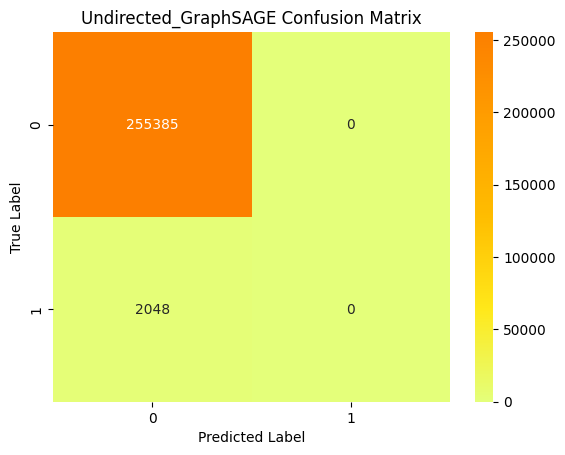



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GraphSAGE
              precision    recall  f1-score   support

           0     0.9920    1.0000    0.9960    254399
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9920    256447
   macro avg     0.4960    0.5000    0.4980    256447
weighted avg     0.9841    0.9920    0.9880    256447



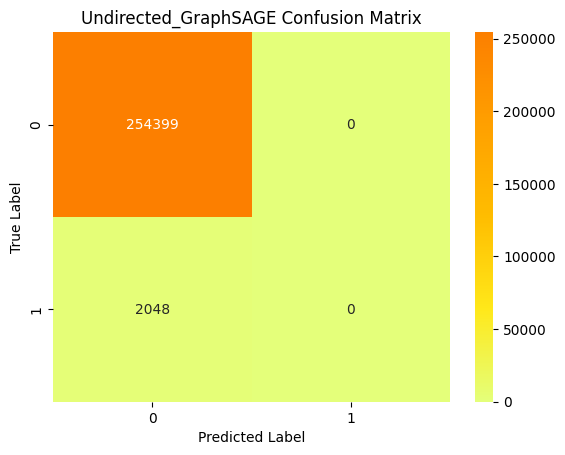



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GraphSAGE
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



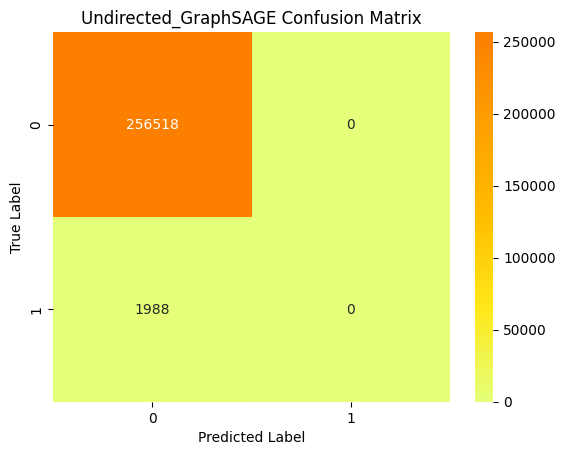



Begin training Directed_GraphSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.39513, Macro recall: 0.84228, Total accuracy: 0.98307, Macro F1-score: 0.69399. Loss backpropagated 3251 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.36237, Macro recall: 0.89380, Total accuracy: 0.98630, Macro F1-score: 0.73734. Loss backpropagated 2743 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.36493, Macro recall: 0.91467, Total accuracy: 0.99263, Macro F1-score: 0.81988. Loss backpropagated 1527 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.36371, Macro recall: 0.88279, Total accuracy: 0.98560, Macro F1-score: 0.72757. Loss backpr

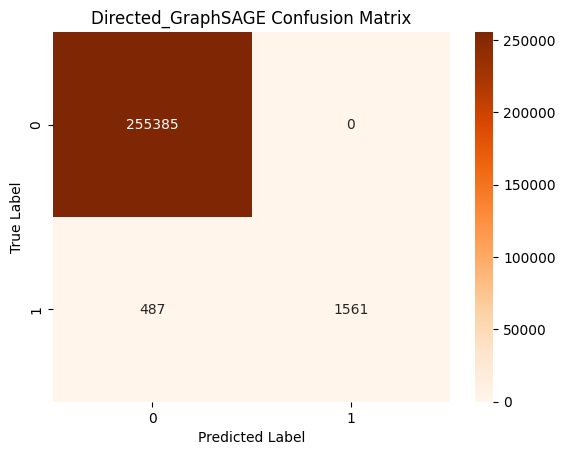



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GraphSAGE
              precision    recall  f1-score   support

           0     0.9987    1.0000    0.9994    254399
           1     1.0000    0.8389    0.9124      2048

    accuracy                         0.9987    256447
   macro avg     0.9994    0.9194    0.9559    256447
weighted avg     0.9987    0.9987    0.9987    256447



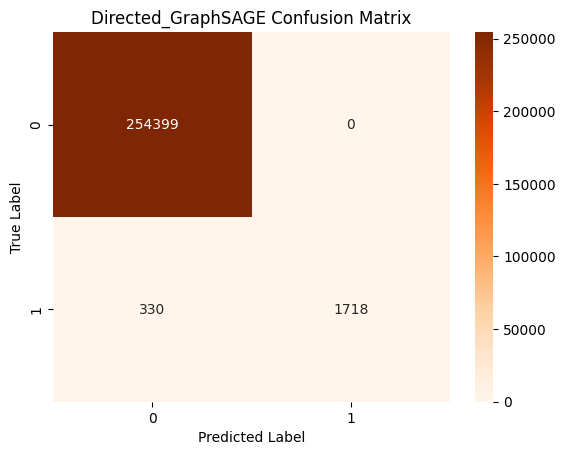



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GraphSAGE
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



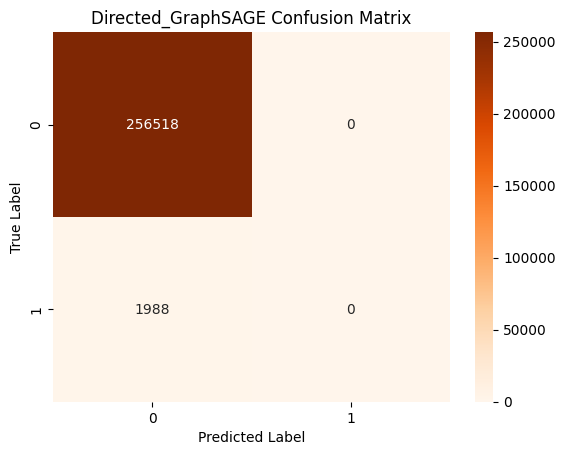

In [ ]:
#SAGE

for setting in settings:
  model_name = f'{setting}_GraphSAGE'
  model = MODELS['spatial'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatial']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatial']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)



Begin training Undirected_GAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.43850, Macro recall: 0.59536, Total accuracy: 0.97174, Macro F1-score: 0.54633. Loss backpropagated 4634 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.43161, Macro recall: 0.57476, Total accuracy: 0.97557, Macro F1-score: 0.54298. Loss backpropagated 4363 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.42614, Macro recall: 0.60714, Total accuracy: 0.97493, Macro F1-score: 0.55815. Loss backpropagated 4296 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.42589, Macro recall: 0.62657, Total accuracy: 0.97264, Macro F1-score: 0.56196. Loss backpropag

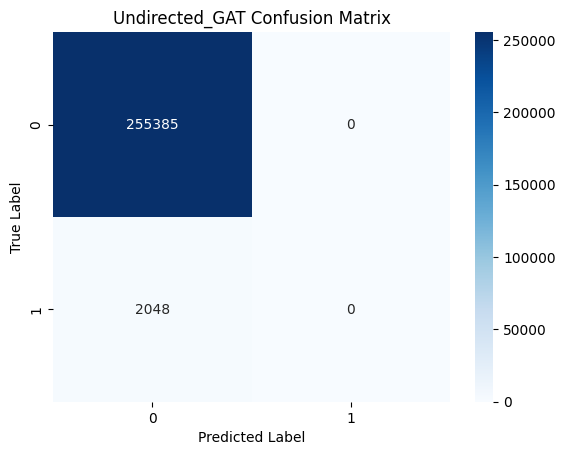



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GAT
              precision    recall  f1-score   support

           0     0.9920    1.0000    0.9960    254399
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9920    256447
   macro avg     0.4960    0.5000    0.4980    256447
weighted avg     0.9841    0.9920    0.9880    256447



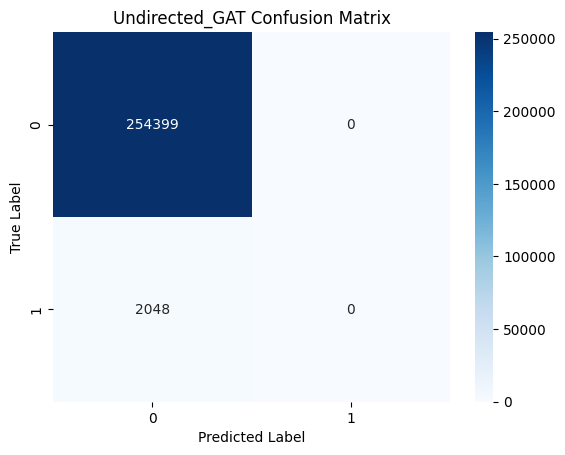



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GAT
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



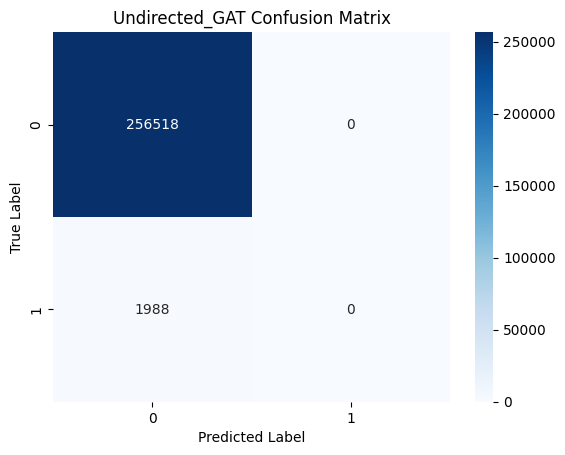



Begin training Directed_GAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.39579, Macro recall: 0.95636, Total accuracy: 0.99798, Macro F1-score: 0.93841. Loss backpropagated 519 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.35029, Macro recall: 0.98062, Total accuracy: 0.99711, Macro F1-score: 0.91990. Loss backpropagated 712 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34495, Macro recall: 0.98059, Total accuracy: 0.99704, Macro F1-score: 0.91836. Loss backpropagated 741 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.33989, Macro recall: 0.98410, Total accuracy: 0.99728, Macro F1-score: 0.92437. Loss backpropagated 

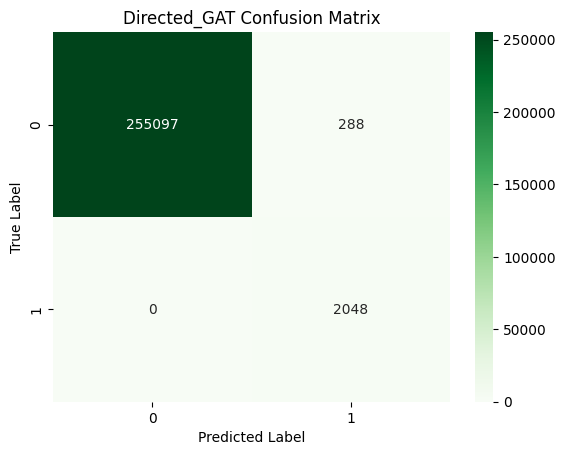



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GAT
              precision    recall  f1-score   support

           0     1.0000    0.9983    0.9991    254399
           1     0.8255    1.0000    0.9044      2048

    accuracy                         0.9983    256447
   macro avg     0.9127    0.9991    0.9518    256447
weighted avg     0.9986    0.9983    0.9984    256447



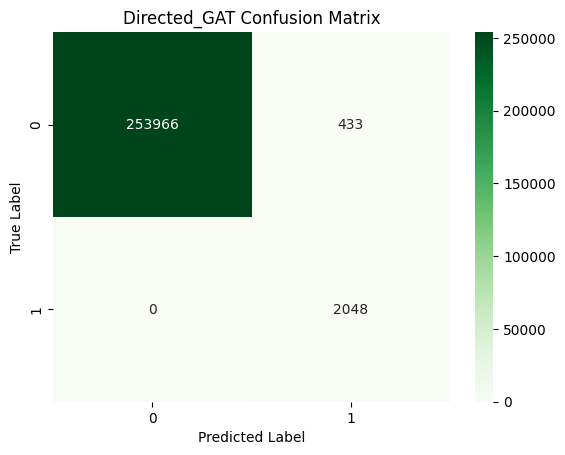



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GAT
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



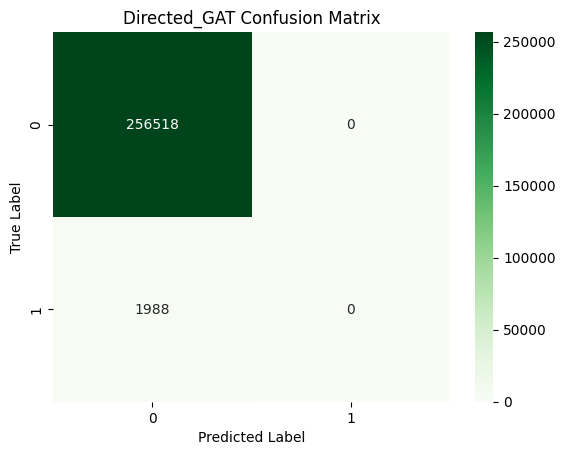

In [ ]:
#GAT

for setting in settings:
  model_name = f'{setting}_GAT'
  model = MODELS['spatial'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatial']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatial']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)

### Spatiotemporal model experiments: Undirected vs. Directed

In [ ]:
train_case = 'Training data list on a single error type: crash_camera_driver1, 1 samples'
train_loader = spatiotemporal_data_loader(experiment_datalists[0]['Training data list on a single error type: crash_camera_driver1, 1 samples'])

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
test1 = 'How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples'
test2 = 'How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples'

test_loader1 = spatiotemporal_data_loader(experiment_datalists[0][test1])
test_loader2 = spatiotemporal_data_loader(experiment_datalists[0][test2])



Begin training Undirected_GRUGCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.58423, Macro recall: 0.94838, Total accuracy: 0.97495, Macro F1-score: 0.67821. Loss backpropagated 2049 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.34199, Macro recall: 0.96230, Total accuracy: 0.97613, Macro F1-score: 0.68753. Loss backpropagated 2045 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34394, Macro recall: 0.94578, Total accuracy: 0.97748, Macro F1-score: 0.69041. Loss backpropagated 2050 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.33823, Macro recall: 0.97437, Total accuracy: 0.97654, Macro F1-score: 0.69270. Loss backpro

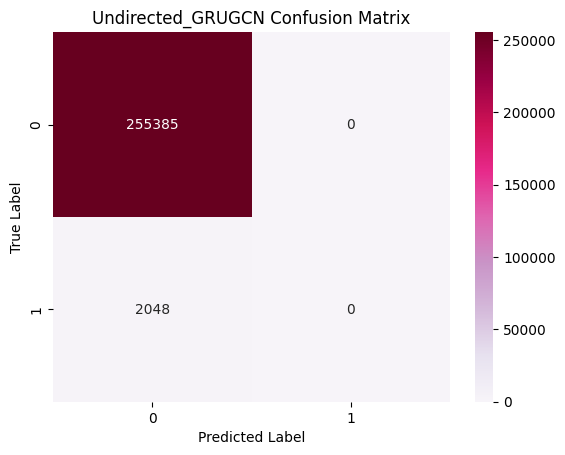



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GRUGCN
              precision    recall  f1-score   support

           0     0.9920    1.0000    0.9960    254399
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9920    256447
   macro avg     0.4960    0.5000    0.4980    256447
weighted avg     0.9841    0.9920    0.9880    256447



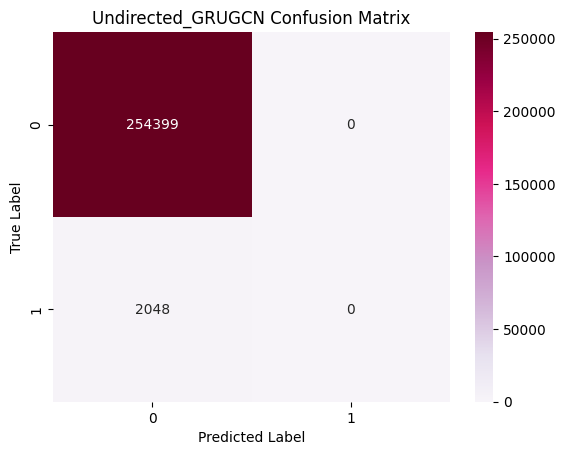



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GRUGCN
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



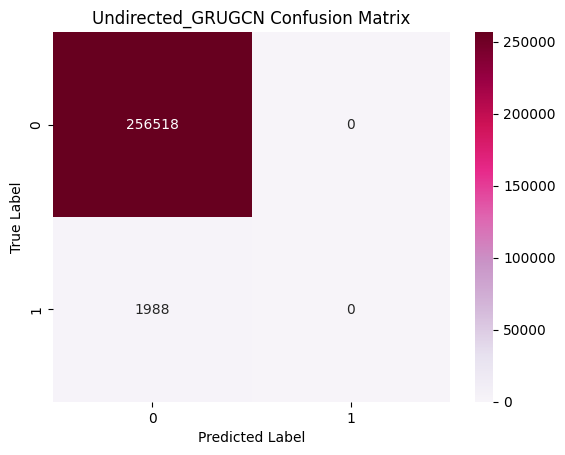



Begin training Directed_GRUGCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.63271, Macro recall: 0.87722, Total accuracy: 0.93611, Macro F1-score: 0.56795. Loss backpropagated 2047 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.34878, Macro recall: 0.94712, Total accuracy: 0.97197, Macro F1-score: 0.66460. Loss backpropagated 2048 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34252, Macro recall: 0.95368, Total accuracy: 0.97632, Macro F1-score: 0.68635. Loss backpropagated 2048 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.34149, Macro recall: 0.96212, Total accuracy: 0.97627, Macro F1-score: 0.68820. Loss backpropa

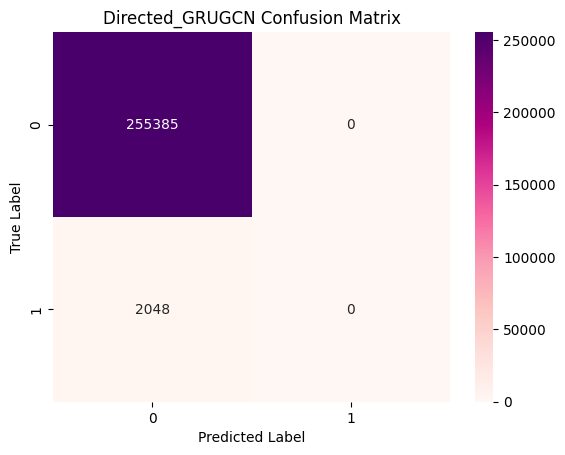



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GRUGCN
              precision    recall  f1-score   support

           0     0.9920    1.0000    0.9960    254399
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9920    256447
   macro avg     0.4960    0.5000    0.4980    256447
weighted avg     0.9841    0.9920    0.9880    256447



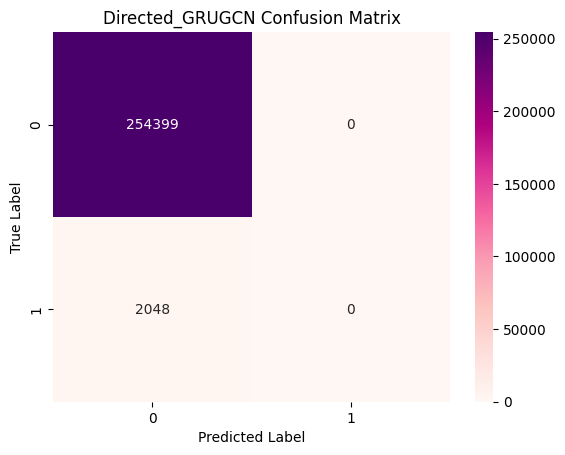



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GRUGCN
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



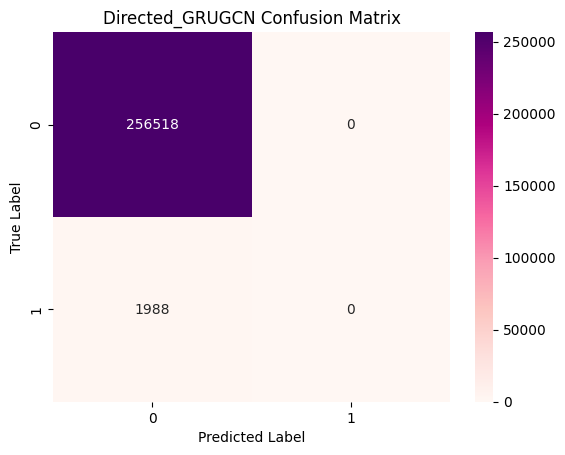

In [ ]:
#GRUGCN

for setting in settings:
  model_name = f'{setting}_GRUGCN'
  model = MODELS['spatiotemporal'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatiotemporal']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)



Begin training Undirected_GRUSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.57132, Macro recall: 0.96244, Total accuracy: 0.97593, Macro F1-score: 0.68772. Loss backpropagated 2048 times.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.35138, Macro recall: 0.95860, Total accuracy: 0.96494, Macro F1-score: 0.64288. Loss backpropagated 2041 times.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34390, Macro recall: 0.94997, Total accuracy: 0.97666, Macro F1-score: 0.68828. Loss backpropagated 2051 times.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.34447, Macro recall: 0.95407, Total accuracy: 0.97373, Macro F1-score: 0.67507. Loss backpr

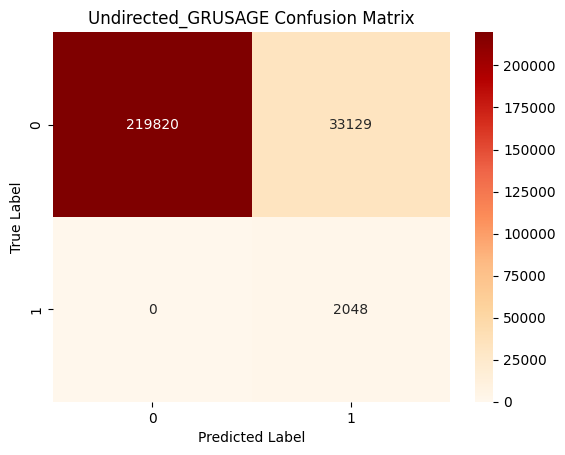



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GRUSAGE
              precision    recall  f1-score   support

           0     1.0000    0.8688    0.9298    262154
           1     0.0567    1.0000    0.1072      2065

    accuracy                         0.8699    264219
   macro avg     0.5283    0.9344    0.5185    264219
weighted avg     0.9926    0.8699    0.9234    264219



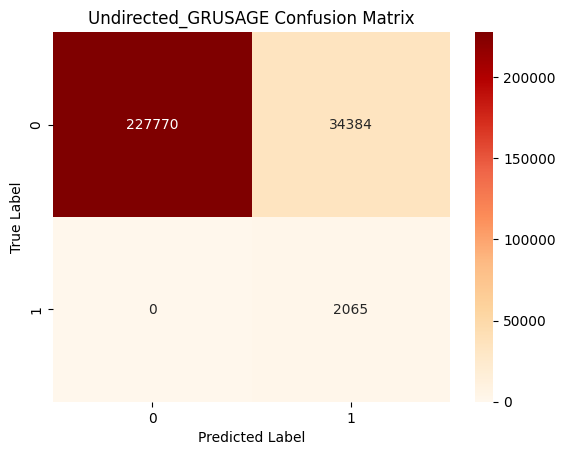



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GRUSAGE
              precision    recall  f1-score   support

           0     1.0000    0.8687    0.9297    260395
           1     0.0552    1.0000    0.1046      1997

    accuracy                         0.8697    262392
   macro avg     0.5276    0.9343    0.5171    262392
weighted avg     0.9928    0.8697    0.9234    262392



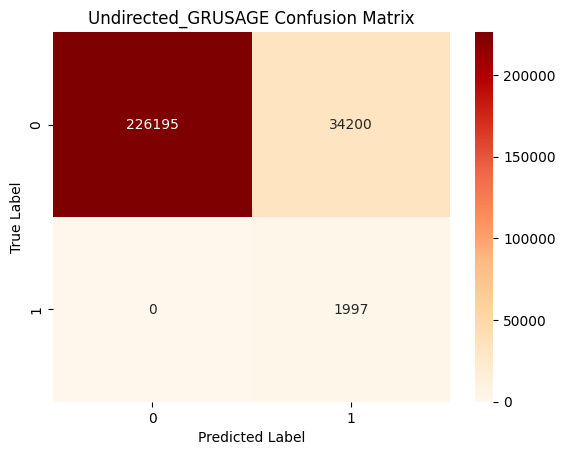



Begin training Directed_GRUSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.53731, Macro recall: 0.98012, Total accuracy: 0.99947, Macro F1-score: 0.98340. Loss backpropagated 134 times.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.33616, Macro recall: 0.98650, Total accuracy: 0.99963, Macro F1-score: 0.98839. Loss backpropagated 83 times.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34801, Macro recall: 0.97658, Total accuracy: 0.98285, Macro F1-score: 0.73369. Loss backpropagated 2055 times.
Total number of graphs: 8793, Presence of class 0: 8793, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.38094, Macro recall: 0.92775, Total accuracy: 0.93161, Macro F1-score: 0.57131. Loss backpropaga

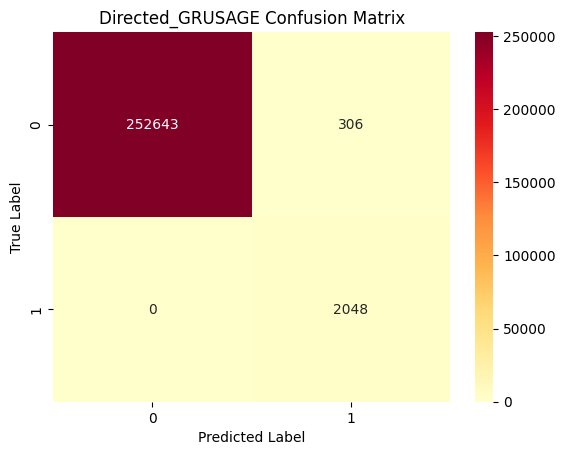



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GRUSAGE
              precision    recall  f1-score   support

           0     0.9952    1.0000    0.9976    262154
           1     1.0000    0.3821    0.5529      2065

    accuracy                         0.9952    264219
   macro avg     0.9976    0.6910    0.7752    264219
weighted avg     0.9952    0.9952    0.9941    264219



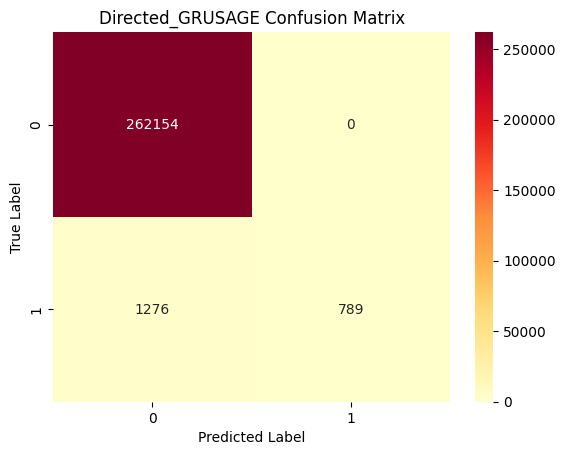



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GRUSAGE
              precision    recall  f1-score   support

           0     0.9924    1.0000    0.9962    260395
           1     0.0000    0.0000    0.0000      1997

    accuracy                         0.9924    262392
   macro avg     0.4962    0.5000    0.4981    262392
weighted avg     0.9848    0.9924    0.9886    262392



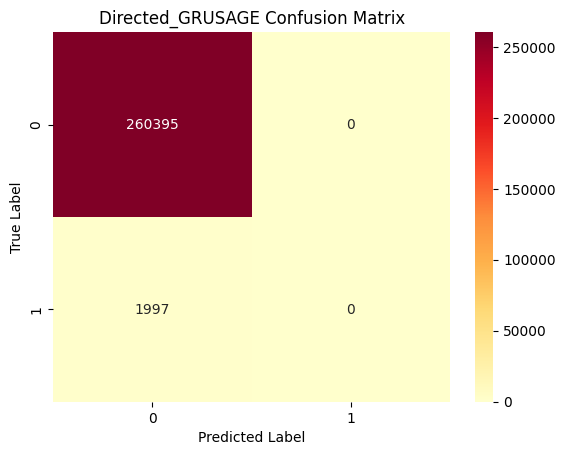

In [ ]:
#GRUSAGE

for setting in settings:
  model_name = f'{setting}_GRUSAGE'
  model = MODELS['spatiotemporal'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatiotemporal']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)



Begin training Undirected_GRUGAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.55767, Macro recall: 0.97248, Total accuracy: 0.97664, Macro F1-score: 0.69274. Loss backpropagated 2048 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.34646, Macro recall: 0.93863, Total accuracy: 0.97771, Macro F1-score: 0.68974. Loss backpropagated 2050 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.37668, Macro recall: 0.93166, Total accuracy: 0.94177, Macro F1-score: 0.58545. Loss backpropagated 2047 times.
Recall score not improving. Early stopping triggered.


Test 1: Evaluate Undirected_GRUGAT on the training dataset.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           

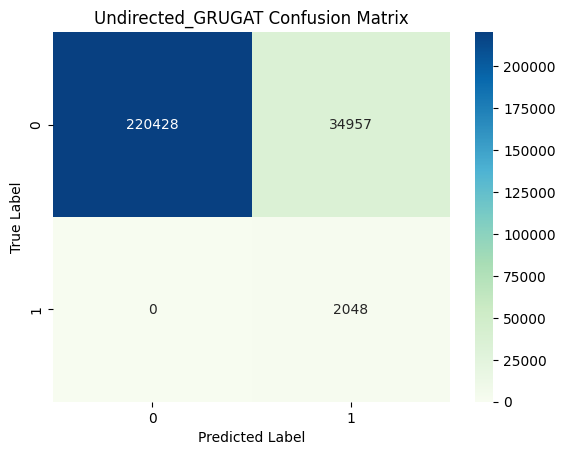



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           0     1.0000    0.8631    0.9265    254399
           1     0.0555    1.0000    0.1052      2048

    accuracy                         0.8642    256447
   macro avg     0.5278    0.9316    0.5159    256447
weighted avg     0.9925    0.8642    0.9200    256447



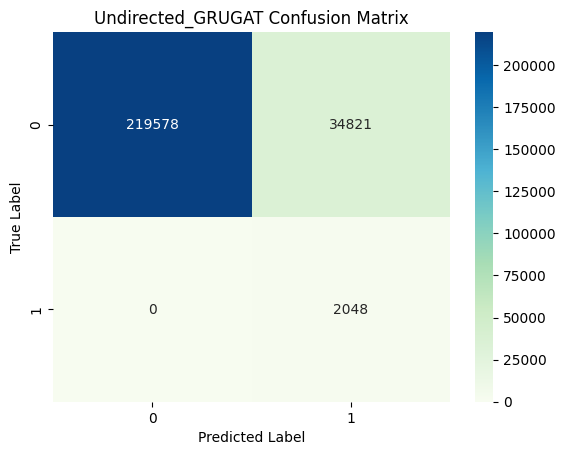



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           0     1.0000    0.8629    0.9264    256518
           1     0.0535    1.0000    0.1016      1988

    accuracy                         0.8640    258506
   macro avg     0.5268    0.9315    0.5140    258506
weighted avg     0.9927    0.8640    0.9201    258506



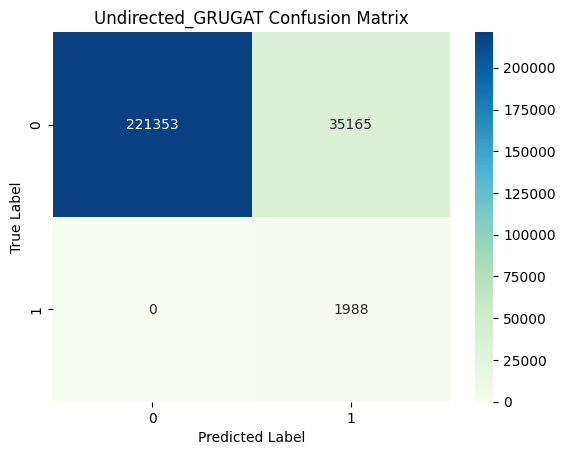



Begin training Directed_GRUGAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.57085, Macro recall: 0.98196, Total accuracy: 0.99929, Macro F1-score: 0.97780. Loss backpropagated 111 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.35389, Macro recall: 0.99798, Total accuracy: 0.99983, Macro F1-score: 0.99462. Loss backpropagated 41 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.33895, Macro recall: 0.99563, Total accuracy: 0.99950, Macro F1-score: 0.98437. Loss backpropagated 73 times.
Total number of graphs: 8877, Presence of class 0: 8877, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.32924, Macro recall: 0.99060, Total accuracy: 0.99864, Macro F1-score: 0.95975. Loss backpropagated

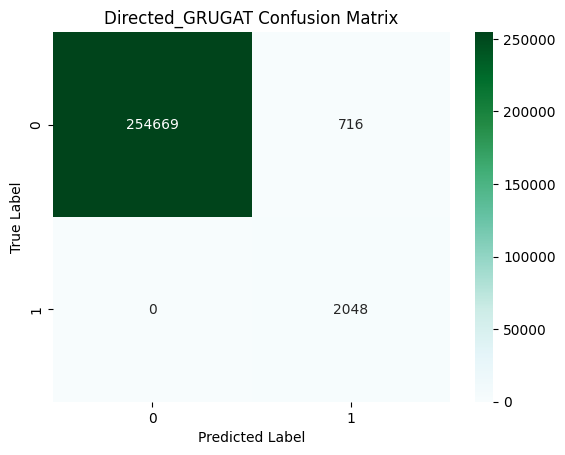



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GRUGAT
              precision    recall  f1-score   support

           0     1.0000    0.9967    0.9983    254399
           1     0.7091    1.0000    0.8298      2048

    accuracy                         0.9967    256447
   macro avg     0.8546    0.9983    0.9141    256447
weighted avg     0.9977    0.9967    0.9970    256447



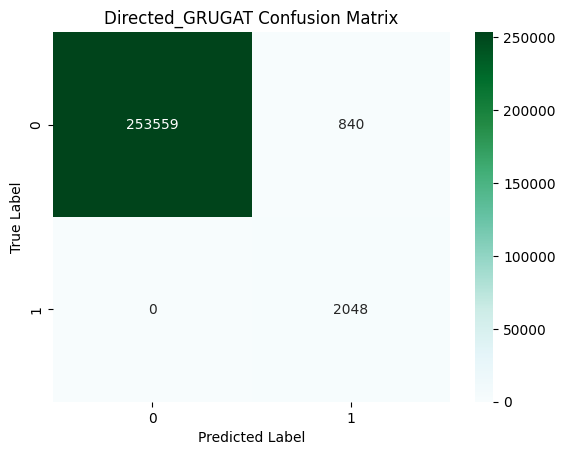



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GRUGAT
              precision    recall  f1-score   support

           0     0.9923    1.0000    0.9961    256518
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9923    258506
   macro avg     0.4962    0.5000    0.4981    258506
weighted avg     0.9847    0.9923    0.9885    258506



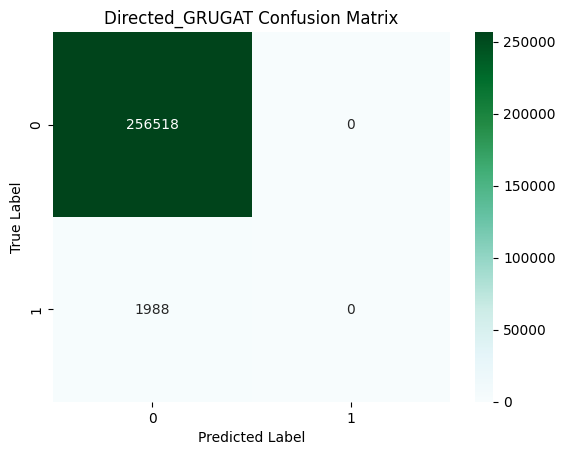

In [ ]:
#GRUGAT

for setting in settings:
  model_name = f'{setting}_GRUGAT'
  model = MODELS['spatiotemporal'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatiotemporal']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)

## Download models

In [ ]:
from google.colab import files

In [ ]:
models = ['GRUSAGE']

In [ ]:
for m in models:
  for setting in settings:
    model_name = f'{setting}_{m}'
    files.download(f'/content/{model_name}_full.pt')
    files.download(f'/content/{model_name}_optimizer.pt')
    files.download(f'/content/{model_name}_weights.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>